In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.sr_dataset import DatasetSR
from PIL import Image as im

from models.EDSR import EDSR
import torch
import torch.nn as nn
from utils.utils import calculate_psnr,calculate_ssim
from tqdm import tqdm
from dataset.sr_dataset import DatasetSR
from einops import rearrange
from torch.utils.data import DataLoader
import cv2

/home/joowan/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


551
37.186961799093424


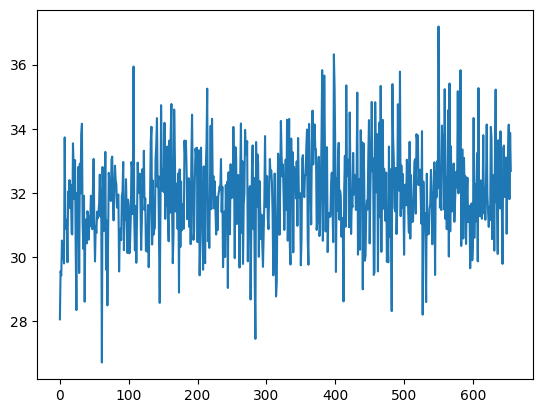

In [21]:
psnr=np.load('psnr.npy')
idx=np.argmax(psnr)
print(idx+1)
print(psnr[idx])
plt.plot(psnr)

In [20]:
second = np.partition(psnr, -2)[-2:]
print(np.where(psnr==second[0]))


(array([398]),)


In [13]:
import numpy as np

# 1차원 배열을 생성합니다.
arr = np.array([10, 20, 30, 40, 50])

# 두 번째로 큰 값의 인덱스를 찾습니다.
second_largest_idx = np.partition(arr, -2)[-2:]

# 결과를 출력합니다.
print(f'Second Largest Index: {second_largest_idx[0]}')

Second Largest Index: 40


In [24]:
device='cuda:0' if torch.cuda.is_available() else 'cpu'
model=EDSR(scale=2)
weight=torch.load('/home/joowan/Desktop/Transformer/experiment/EDSR/best.pt')
model.load_state_dict(weight)
model.to(device)

val_dataset=DatasetSR(phase='val')
val_dataloader=DataLoader(val_dataset,batch_size=1,num_workers=1,shuffle=True)

val_tq=tqdm(val_dataloader, ncols=80, smoothing=0, bar_format='val: {desc}|{bar}{r_bar}')

current_loss=0
psnr=0
ssim=0
criterion=nn.L1Loss()
with torch.no_grad():
    for idx,imgs in enumerate(val_tq):
        HR_img=imgs['H'].to(device)
        LR_img=imgs['L'].to(device)
        
        output_img=model(LR_img)
        current_loss+=criterion(output_img,HR_img)
        
        output_img=output_img[0].cpu().numpy()
        HR_img=HR_img[0].cpu().numpy()
        output_img=(rearrange(output_img,'c h w -> h w c'))
        HR_img=(rearrange(HR_img,'c h w -> h w c'))

        psnr+=calculate_psnr(output_img,HR_img,crop_border=8)
        ssim+=calculate_ssim(output_img,HR_img,crop_border=8)
        
        
        #####################
        # save result image #
        #####################
        output_img=cv2.cvtColor(output_img,cv2.COLOR_BGR2RGB)
        HR_img=cv2.cvtColor(HR_img,cv2.COLOR_BGR2RGB)
        LR_img=LR_img[0].cpu().numpy()
        LR_img=(rearrange(LR_img,'c h w -> h w c'))
        LR_img=cv2.cvtColor(LR_img,cv2.COLOR_BGR2RGB)
        LR_img=cv2.resize(LR_img,(output_img.shape[1],output_img.shape[0]),)
        
        # cv2.imwrite(f'SR_{idx}.png',output_img)
        # cv2.imwrite(f'HR_{idx}.png',HR_img)
        # cv2.imwrite(f'LR_{idx}.png',LR_img)
        
        
    epoch_loss=current_loss / 100
    avg_psnr=psnr / 100
    avg_ssim=ssim / 100
    
    print(avg_psnr)
    print(avg_ssim)
    
    

val: |███████████████████████████████▌         | 77/100 [01:03<00:18,  1.22it/s]